In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from gyms.sim_library import get_custom_windy_gridworld_simulator
import os
import pickle
from reward_model import OracleRewardModel
from transition_model import OracleTransitionModel
import itertools
import torch
from matplotlib.ticker import ScalarFormatter


In [ ]:

def get_Qs(model_version):
    experiment_folder = ''
    folders = {
        'timing_smart': '10-09-2023_01:55:22_custom_windygridTAG_200Epochs_uniformGreedyDelay_FalseOracleReward_FalseOracleTransition_FalseSGD_TrueCondensedReward_[0.1, 0.1]Epsilon_0Explore',
        'timing_dumb': '10-09-2023_01:55:22_custom_windygridTAG_200Epochs_uniformGreedyDelay_FalseOracleReward_FalseOracleTransition_FalseSGD_TrueCondensedReward_[0.1, 0.1]Epsilon_0Explore',
        'model_free': '05-25-2023_06:59:02_custom_windygridTAG_200Epochs_uniformGreedyDelay_FalseOracleReward_FalseOracleTransition_FalseSGD_TrueCondensedReward_[0.1, 0.1]Epsilon_0Explore',
        'oracle': '10-15-2023_01:03:47_custom_windygridTAG_200Epochs_uniformGreedyDelay_TrueOracleReward_TrueOracleTransition_FalseSGD_FalseCondensedReward_[0.1, 0.1]Epsilon_0Explore',
    }
    model_name = {
        'timing_smart': 'Timing-Aware',
        'timing_dumb': 'Timing-Naive',
        'model_free': 'Model-Free',
        'oracle': 'Oracle',
    }[model_version]

    Q_fpath = os.path.join(experiment_folder + folders[model_version], 'Qs.pkl')
    with open(Q_fpath, 'rb') as fin:
        Qs = pickle.load(fin)
    return model_name, Qs

In [20]:
def get_oracle_Q():
    gamma = 0.99
    action_cost = 1
    env = get_custom_windy_gridworld_simulator(
        gamma, action_cost, horizon=None, 
        hazards=True, start_state='default', stochastic_wind=True, goal_reward=10000)
    actions = env.actions
    states = env.states
    delta_names = range(1, 11)
    deltas = list(range(len(delta_names)))
    device = torch.device('cpu')
    dumb = False
    terminal_state = env.terminal_state
    is_windygrid = ('windygrid' in env.name)

    transition = OracleTransitionModel(env, actions, states, delta_names, device, dumb=dumb)
    R = OracleRewardModel(
        env, 
        states, actions, deltas, delta_names,
        terminal_state, gamma, action_cost,
        device,
        is_windygrid=is_windygrid
    )

    Q = torch.zeros((len(actions), len(states), len(deltas))).to(device)
    action_cost = 1
    T = transition()

    def update_smart_timing_based_Q(Q, R, T, actions, deltas, delta_names, states, gamma, device,
                                    cost=5, Q_iters=50, sgd_update=False, alpha=0.5, 
                                    condensed_reward=False, terminal_state=2, t=None, 
                                    transition=None, verbose=False, is_windygrid=False):
        """Update Q based on predictions from R.

        Q_iters: number of iterations of Q updates. If None, iterates to convergence.
        cost: cost of performing an action. if unknown, cost = 0.

        run just this w/ oracle until it's converged, then take & see that it does at least as well as model free
        """
        prev_Q = Q.clone().detach()
        converged = 0
        with torch.no_grad():
            for i in range(Q_iters):
                for (s, a, d) in itertools.product(states, actions, list(reversed(deltas))):  # updates along the way; could freeze instead
                    if condensed_reward:
                        r = R.get_prediction(s, a, 0, transition)
                    else:
                        r = R.get_prediction(s, a, 0)
                    if delta_names[d] <= 1:
                        expected_Q = T[a, s, :].dot(Q.max(axis=0).values.max(axis=-1).values)
                        new_Q = r + (gamma * expected_Q)
                        if sgd_update:
                            Q[a, s, d] = Q[a, s, d] + alpha * (new_Q - Q[a, s, d])
                        else:
                            Q[a, s, d] = new_Q
                    else:
                        dminus1_idx = delta_names.index(delta_names[d] - 1)
                        expected_Q = T[a, s, :].dot(Q[a, :, dminus1_idx])
                        if s == terminal_state:
                            cost_adjustment = torch.Tensor([0]).to(device)
                        else:
                            if terminal_state is not None:
                                adj = T[a, s, terminal_state]
                            else:
                                adj = 0
                            cost_adjustment = torch.Tensor([cost * gamma * (1 - adj)]).to(device)
                        new_Q = r + cost_adjustment + (gamma * expected_Q)
                        if sgd_update:
                            Q[a, s, d] = Q[a, s, d] + alpha * (new_Q - Q[a, s, d])
                        else:
                            Q[a, s, d] = new_Q
                if Q.equal(prev_Q):
                    converged += 1
                else:
                    converged = 0

                if converged > 3:
                    if verbose:
                        print(f'Q converged after {i} iterations')
                    break
                
                prev_Q = Q.clone().detach()
        return Q

    Q_iters = 100
    sgd_update = False
    sgd_lr = 0.3
    condensed_reward = False
    t = 0

    Q = update_smart_timing_based_Q(
        Q, R, T, 
        actions, deltas, delta_names, states, gamma, device,
        cost=env.cost, Q_iters=Q_iters, sgd_update=sgd_update, alpha=sgd_lr,
        condensed_reward=condensed_reward, terminal_state=terminal_state, t=t, transition=transition,
        is_windygrid=is_windygrid,
        verbose=True)
    return Q

In [94]:
def plot_windygrid_Q(Q, env, ax, fig, model_name, cbar=False):
    heatmap = np.zeros((7, 10))
    action_map = {}
    for s in env.states:
        coords = env.idx_to_state[s]
        Q_vals = Q[:, s, :]
        best = (Q_vals>=torch.max(Q_vals)).nonzero()
        for d1 in range(best.shape[0]):
            max_a, max_d = best[d1].detach().flatten()
            move = env.idx_to_action[max_a.item()]
            heatmap[coords[0]][coords[1]] = Q_vals.max()
            action_map[(coords[0], coords[1])] = action_map.get((coords[0], coords[1]), []) + [[env.move_to_dir[move], max_d]]
    vmin = heatmap.min()
    vmax = heatmap.max()
    for i in range(7):
        for j in range(10):
            if (i, j) == (3, 7):
                ax.scatter(7, 3, s=320, marker='*', color='black')
                continue
            if (i, j) in [(2, 5), (2,4)]:
                ax.scatter(j, i, s=80, marker='x', color='tab:red')
            for (direction, delay) in action_map[(i,j)]:
                direction = direction[1], direction[0]
                ax.arrow(j, i, direction[0] /4, direction[1]/4, head_width=0.1, head_length=0.1)
                if list(direction) == [0, 1]:  # DOWN
                    ax.annotate(f'{int(delay) + 1}',
                                xy=(j + direction[0] /8, i + direction[1]/8),
                                xytext=(3, -6),
                                textcoords='offset points')
                elif list(direction) == [1, 0]:  # RIGHT
                    ax.annotate(f'{int(delay) + 1}',
                                xy=(j + direction[0] /8, i + direction[1]/8),
                                xytext=(-2, 5),
                                textcoords='offset points')
                elif list(direction) == [-1, 0]:  # LEFT
                    ax.annotate(f'{int(delay) + 1}',
                                xy=(j + direction[0] /8, i + direction[1]/8),
                                xytext=(-5, -10),
                                textcoords='offset points')
                elif list(direction) == [0, -1]:  # UP
                    ax.annotate(f'{int(delay) + 1}',
                                xy=(j + direction[0] /8, i + direction[1]/8),
                                xytext=(-10, 0),
                                textcoords='offset points')
                else:
                    print('MISSING: ', direction)
    ax.set_title(f'{model_name} Q-values', fontsize=16)
    im = ax.imshow(heatmap, vmin=vmin, vmax=vmax)
    if cbar:
        plt.tight_layout()
        fig.subplots_adjust(right=0.8)
        plt.subplots_adjust(hspace=0.9)
        cbar_ax = fig.add_axes([0.81, 0.25, 0.015, 0.5])
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)  # Disable scientific notation
        formatter.set_powerlimits((0,0))  # Customize the range where scientific notation is applied
        cbar = fig.colorbar(im, cax=cbar_ax, format=formatter)
        cbar.ax.set_ylabel('Q values', fontsize=14)

    return fig


In [84]:
oracle_Q = get_oracle_Q()

start state:  (3, 0)


start state:  (3, 0)
start state:  (3, 0)
start state:  (3, 0)


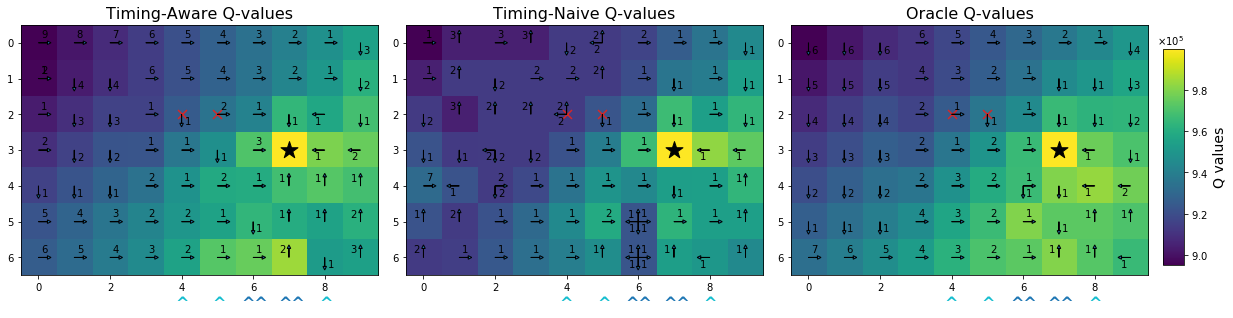

In [96]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

ax = axes[0]
model_version = 'timing_smart'
model_name, Qs = get_Qs(model_version)
deltas = range(10)
if model_version == 'oracle':
    Q = Qs['timing_dumb']
else:
    Q = Qs[model_version]
gamma = 0.99
action_cost = 1
env = get_custom_windy_gridworld_simulator(
    gamma, action_cost, horizon=None, 
    hazards=True, start_state='default', stochastic_wind=True, goal_reward=10000)
fig = plot_windygrid_Q(Q, env, ax, fig, model_name)
plt.gcf().text(0.124, 0.15, '^', fontsize=16, fontweight='bold', color='tab:cyan')
plt.gcf().text(0.15, 0.15, '^', fontsize=16, fontweight='bold', color='tab:cyan')
plt.gcf().text(0.17, 0.15, '^^', fontsize=16, fontweight='bold', color='tab:blue')
plt.gcf().text(0.196, 0.15, '^^', fontsize=16, fontweight='bold', color='tab:blue')
plt.gcf().text(0.224, 0.15, '^', fontsize=16, fontweight='bold', color='tab:cyan')

ax = axes[1]
model_version = 'timing_dumb'
model_name, Qs = get_Qs(model_version)
deltas = range(10)
if model_version == 'oracle':
    Q = Qs['timing_dumb']
else:
    Q = Qs[model_version]
gamma = 0.99
action_cost = 1
env = get_custom_windy_gridworld_simulator(
    gamma, action_cost, horizon=None, 
    hazards=True, start_state='default', stochastic_wind=True, goal_reward=10000)
fig = plot_windygrid_Q(Q, env, ax, fig, model_name, cbar=True)
offset = 0.267
plt.gcf().text(0.124 + offset, 0.15, '^', fontsize=16, fontweight='bold', color='tab:cyan')
plt.gcf().text(0.15 + offset, 0.15, '^', fontsize=16, fontweight='bold', color='tab:cyan')
plt.gcf().text(0.17 + offset, 0.15, '^^', fontsize=16, fontweight='bold', color='tab:blue')
plt.gcf().text(0.196 + offset, 0.15, '^^', fontsize=16, fontweight='bold', color='tab:blue')
plt.gcf().text(0.224 + offset, 0.15, '^', fontsize=16, fontweight='bold', color='tab:cyan')


ax = axes[2]
Q = oracle_Q
model_name = 'Oracle'
gamma = 0.99
action_cost = 1
env = get_custom_windy_gridworld_simulator(
    gamma, action_cost, horizon=None, 
    hazards=True, start_state='default', stochastic_wind=True, goal_reward=10000)
fig = plot_windygrid_Q(Q, env, ax, fig, model_name)
offset = 0.267 * 2
plt.gcf().text(0.124 + offset, 0.15, '^', fontsize=16, fontweight='bold', color='tab:cyan')
plt.gcf().text(0.15 + offset, 0.15, '^', fontsize=16, fontweight='bold', color='tab:cyan')
plt.gcf().text(0.17 + offset, 0.15, '^^', fontsize=16, fontweight='bold', color='tab:blue')
plt.gcf().text(0.196 + offset, 0.15, '^^', fontsize=16, fontweight='bold', color='tab:blue')
plt.gcf().text(0.224 + offset, 0.15, '^', fontsize=16, fontweight='bold', color='tab:cyan')

plt.savefig(f'Q_values_all.pdf', dpi=300, bbox_inches='tight')
# plt.savefig(f'Q_values_{model_version}.pdf', dpi=300, bbox_inches='tight')